In [1]:
import numpy as np
import networkx as nx
import copy
import pandas as pd
import xlwt
import torch
from torch import nn
import torch.optim as optim
from torch_geometric.utils import from_networkx
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn.conv import MessagePassing
from torch_sparse import SparseTensor, matmul
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_nodes = 5
num_edges = 6
n = 100
m = 300
k = 60
train_num = 1000
test_num = 100
num_layers = 50
nnz = 30

#less nnz =5; m = 50; k = 10

def metropolis(adjacency_matrix):
    num_of_nodes = adjacency_matrix.shape[0]
    metropolis=np.zeros((num_of_nodes,num_of_nodes))
    for i in range(num_of_nodes):
        for j in range(num_of_nodes):
            if adjacency_matrix[i,j]==1:
                d_i = np.sum(adjacency_matrix[i,:])
                d_j = np.sum(adjacency_matrix[j,:])
                metropolis[i,j]=1/(1+max(d_i,d_j))
        metropolis[i,i]=1-sum(metropolis[i,:])
    return metropolis

class SynDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
        self.A = []; 
        self.y = []; 
        self.x_true = []
        self.pyg_data=[]
        self.process()
        
        
    def gen_func(self, num_of_nodes, n, m, k):
        A_all = np.random.randn(m, n)
        x = np.random.randn(n)
        x_norm = 0

        while(x_norm < 1e-2):
            x_mask = np.random.rand(n)
            x_mask[x_mask < 1 - nnz/100] = 0
            x_mask[x_mask > 0] = 1
            x_norm = np.linalg.norm(x * x_mask)

        x = x * x_mask
        x = x/np.linalg.norm(x)
        
        SNR_db = 30
        SNR = 10**(SNR_db/10)
        
        noise = np.random.randn(m) * np.sqrt(1/SNR)
        y_all = A_all@x + noise

        A = np.zeros((num_of_nodes, k , n))
        y = np.zeros((num_of_nodes, k))
        for ii in range(num_of_nodes):
            start = (k*ii) % m; end = (k*(ii+1) )%m
            if(start > end):
                A[ii,:,:] = np.concatenate((A_all[start:,:],A_all[:end,:]), axis = 0)
                y[ii,:] = np.concatenate((np.expand_dims(y_all[start:], axis = 0), 
                                          np.expand_dims(y_all[:end], axis = 0)), axis = 1)
            else:
                A[ii,:,:] = A_all[start:end,:]
                y[ii,:] = np.expand_dims(y_all[start:end], axis = 0)
                
        x = np.expand_dims(x, axis = 0)
        x = x.repeat(num_of_nodes, axis = 0)
        
        return A, y, x

    def gen_graph(self, num_of_nodes, num_of_edges, directed=False, add_self_loops=True):
        G = nx.gnm_random_graph(num_of_nodes, num_of_edges, directed=directed)
        k = 0
        while (nx.is_strongly_connected(G) if directed else nx.is_connected(G)) == False:
            G = nx.gnm_random_graph(num_of_nodes, num_of_edges, directed=directed)
            k += 1
        # print("Check if connected: ", nx.is_connected(G))
        # nx.draw(G)
        
        edge_index = from_networkx(G).edge_index
        adj = nx.to_numpy_matrix(G)
        return G, adj,edge_index
        
    def process(self):
        _, adj,edge_index = self.gen_graph(num_nodes, num_edges)
        self.edge_index = edge_index
        W = metropolis(adj)
        self.W = [torch.tensor(W, dtype = torch.float)] * self.samples
        
        
        for ii in range(self.samples):
            A, y, x_true = self.gen_func(num_nodes, n, m, k)
            self.A.append(torch.tensor(A, dtype = torch.float) ); 
            self.y.append(torch.tensor(y, dtype = torch.float) ); 
            self.x_true.append(torch.tensor(x_true, dtype = torch.float) )
            
            edge_weight=torch.tensor(W,dtype=torch.float)
            self.pyg_data.append(Data(edge_weight=SparseTensor.from_dense(edge_weight)))        
        
        

    def __getitem__(self, idx):
        return self.W[idx], self.A[idx], self.y[idx], self.x_true[idx], self.pyg_data[idx]

    def __len__(self):
        """Number of graphs in the dataset"""
        return len(self.A)
    
    
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    W, A, y, x_true, pyg_data = map(list, zip(*samples))
    W = torch.stack(W)
    A = torch.stack(A)
    y = torch.stack(y)
    x_true = torch.stack(x_true)
    pyg_data = Batch.from_data_list(pyg_data)
    return W, A, y, x_true, pyg_data
class MetropolisConv(MessagePassing):
    def __init__(self):
        super(MetropolisConv, self).__init__(aggr='add')  # "Add" aggregation.

    def forward(self, x, pyg_data):
        (B, N, D)=x.shape
        out = self.propagate(x=x.view(-1,D), edge_index=pyg_data.edge_weight, node_dim=-1)
        return out.view(B,N,D)

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)
def step_loss(gamma,x, y):
    #gamma = 0.75
    n_steps = x.shape[0]
    #print(n_steps)
    di = torch.ones((n_steps)) * gamma
    power = torch.tensor(range(n_steps, 0, -1))
    gamma_a = di ** power
    gamma_a = gamma_a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

    y = torch.unsqueeze(y, axis = 0)
    ele_loss = gamma_a * (x - y) **2
    #print(ele_loss.shape)
    #print(torch.mean(ele_loss,  (1,2,3) ))
    loss = torch.mean(ele_loss)
    return loss


train_data = SynDataset(train_num)
val_data = SynDataset(test_num)
test_data = SynDataset(test_num)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, collate_fn=collate)

/home/xiezhq/.wanghe_env/lib/python3.7/site-packages/torch_sparse/tensor.py:46: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  index = mat.nonzero()


# GNN-PGEXTRA

In [2]:
class Net_PGEXTRA(torch.nn.Module):
    def __init__(self, step_size, num_layers):
        super(Net_PGEXTRA, self).__init__()
        self.step_size = nn.Parameter(torch.ones(num_layers)*step_size)
        self.lam = nn.Parameter(torch.ones(num_layers)*step_size*10)
        self.num_layers = num_layers
        self.conv=MetropolisConv()
    def tgrad_qp(self, A, b, x):
        # A: nodes * k * n
        # X: nodes * n
        # Y: nodes * k
        '''grad_A = np.zeros(x.shape)
        for i in range(x.shape[0]):
            grad_A[i] = A[i].T @ (A[i] @ x[i] - b[i])
        return grad_A'''
        x_ = torch.unsqueeze(x, axis = -1)
        b_ = torch.unsqueeze(b, axis = -1)

        A_t = A.transpose(2,3)
        grad_A = A_t @ (A @ x_ - b_)
        #print(A.shape, x.shape, b.shape)
        #print(grad_A.shape)
        grad_A = torch.squeeze(grad_A, axis = -1)
        #print(grad_A.shape)
        return grad_A
    
    def act(self, x, ii):
        tau = self.lam[ii] #* self.step_size[ii]
        return F.relu(x - tau) - F.relu( - x - tau)
            
    def forward(self, W, A, b,pyg_data, max_iter):
        (batch_size, num_of_nodes, _, dim) = A.shape
        init_x = torch.zeros((batch_size, num_of_nodes, dim))
        ret_z = []
        
        k = 1
        x_0 = init_x
        x_12 = self.conv(x_0,pyg_data) - self.step_size[0] * self.tgrad_qp(A, b, x_0)
        x_1 = self.act(x_12, 0)
        
        x_hist = [init_x,x_1]
        while (k < max_iter):
            x_32 = self.conv(x_1,pyg_data) + x_12 - (self.conv(x_0,pyg_data) + x_0)/2 - \
                self.step_size[k] * (self.tgrad_qp(A, b, x_1)-self.tgrad_qp(A, b, x_0))
            x_2 = self.act(x_32, k)
            
            ret_z.append(x_2)

            x_0 = x_1
            x_1 = x_2
            x_12 = x_32

            k = k + 1
            x_hist.append(x_2)
        
        ret_z = torch.stack(ret_z)
        return ret_z, x_2,x_hist
      
###main
model_PGEXTRA = Net_PGEXTRA(1e-3, num_layers)
optimizer = optim.Adam(model_PGEXTRA.parameters(), lr=1e-4)
model_PGEXTRA.train()
epoch_losses = []
for epoch in range(500):
    epoch_loss = 0
    for iter, (W, A, y, x_true,pyg_data) in enumerate(train_loader):
        z, _,_ = model_PGEXTRA(W, A, y, pyg_data,num_layers)
        loss = step_loss(0.83,z, x_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    if(epoch % 10 == 0):
        print(epoch_loss, model_PGEXTRA.lam[1], model_PGEXTRA.step_size[1])

0.00015240458333209972 tensor(0.0080, grad_fn=<SelectBackward>) tensor(0.0007, grad_fn=<SelectBackward>)
1.5373161836862437e-06 tensor(0.0050, grad_fn=<SelectBackward>) tensor(0.0026, grad_fn=<SelectBackward>)
7.83289729966441e-07 tensor(0.0044, grad_fn=<SelectBackward>) tensor(0.0030, grad_fn=<SelectBackward>)
6.118405604382815e-07 tensor(0.0037, grad_fn=<SelectBackward>) tensor(0.0033, grad_fn=<SelectBackward>)
5.260294031472768e-07 tensor(0.0032, grad_fn=<SelectBackward>) tensor(0.0035, grad_fn=<SelectBackward>)
4.6372197815003346e-07 tensor(0.0028, grad_fn=<SelectBackward>) tensor(0.0037, grad_fn=<SelectBackward>)
4.20715747573297e-07 tensor(0.0024, grad_fn=<SelectBackward>) tensor(0.0039, grad_fn=<SelectBackward>)
3.883507488922078e-07 tensor(0.0021, grad_fn=<SelectBackward>) tensor(0.0041, grad_fn=<SelectBackward>)
3.4693574679778294e-07 tensor(0.0019, grad_fn=<SelectBackward>) tensor(0.0042, grad_fn=<SelectBackward>)
3.213548982472503e-07 tensor(0.0018, grad_fn=<SelectBackward>)

# GNN-DGD

In [3]:
class Net_DGD(torch.nn.Module):
    def __init__(self, step_size, num_layers):
        super(Net_DGD, self).__init__()
        self.step_size = nn.Parameter(torch.ones(num_layers)*step_size)
        self.lam = nn.Parameter(torch.ones(num_layers)*step_size*10)
        self.num_layers = num_layers
        self.conv=MetropolisConv()
    def tgrad_qp(self, A, b, x):
        # A: nodes * k * n
        # X: nodes * n
        # Y: nodes * k
        '''grad_A = np.zeros(x.shape)
        for i in range(x.shape[0]):
            grad_A[i] = A[i].T @ (A[i] @ x[i] - b[i])
        return grad_A'''
        x_ = torch.unsqueeze(x, axis = -1)
        b_ = torch.unsqueeze(b, axis = -1)

        A_t = A.transpose(2,3)
        grad_A = A_t @ (A @ x_ - b_)
        #print(A.shape, x.shape, b.shape)
        #print(grad_A.shape)
        grad_A = torch.squeeze(grad_A, axis = -1)
        #print(grad_A.shape)
        return grad_A
    
    def act(self, x, ii):
        tau = self.lam[ii] #* self.step_size[ii]
        return F.relu(x - tau) - F.relu( - x - tau)
            
    def forward(self, W, A, b,pyg_data, max_iter):
        (batch_size, num_of_nodes, _, dim) = A.shape
        init_x = torch.zeros((batch_size, num_of_nodes, dim))
        ret_z = []
        
        k = 1
        x_0 = init_x
        x_12 = self.conv(x_0,pyg_data) - self.step_size[0] * self.tgrad_qp(A, b, x_0)
        x_1 = self.act(x_12, 0)
        
        x_hist = [init_x,x_1]
        while (k < max_iter):
            #x_32 = self.conv(x_1,pyg_data) + x_12 - (self.conv(x_0,pyg_data) + x_0)/2 - \
            #    self.step_size[k] * (self.tgrad_qp(A, b, x_1)-self.tgrad_qp(A, b, x_0))
            x_32 = self.conv(x_1,pyg_data) - self.step_size[k] * self.tgrad_qp(A, b, x_1)
            x_2 = self.act(x_32, k)
            
            ret_z.append(x_2)

            x_0 = x_1
            x_1 = x_2
            x_12 = x_32

            k = k + 1
            x_hist.append(x_2)
        
        ret_z = torch.stack(ret_z)
        return ret_z, x_2,x_hist


model_DGD = Net_DGD(1e-3, num_layers)
optimizer = optim.Adam(model_DGD.parameters(), lr=1e-4)
model_DGD.train()
epoch_losses = []
for epoch in range(500):
    epoch_loss = 0
    for iter, (W, A, y, x_true,pyg_data) in enumerate(train_loader):
        z, _,_ = model_DGD(W, A, y, pyg_data,num_layers)
        loss = step_loss(0.93,z, x_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    if(epoch % 10 == 0):
        print(epoch_loss, model_DGD.lam[1], model_DGD.step_size[1])

0.0005299581494000449 tensor(0.0075, grad_fn=<SelectBackward>) tensor(0.0033, grad_fn=<SelectBackward>)
7.238334751491493e-05 tensor(0.0070, grad_fn=<SelectBackward>) tensor(0.0035, grad_fn=<SelectBackward>)
5.440667541734001e-05 tensor(0.0068, grad_fn=<SelectBackward>) tensor(0.0038, grad_fn=<SelectBackward>)
4.628787928595557e-05 tensor(0.0066, grad_fn=<SelectBackward>) tensor(0.0040, grad_fn=<SelectBackward>)
4.289864750717243e-05 tensor(0.0064, grad_fn=<SelectBackward>) tensor(0.0043, grad_fn=<SelectBackward>)
4.171779494299699e-05 tensor(0.0064, grad_fn=<SelectBackward>) tensor(0.0045, grad_fn=<SelectBackward>)
4.090801394340815e-05 tensor(0.0063, grad_fn=<SelectBackward>) tensor(0.0048, grad_fn=<SelectBackward>)
4.00582073325495e-05 tensor(0.0062, grad_fn=<SelectBackward>) tensor(0.0052, grad_fn=<SelectBackward>)
3.9135704128057114e-05 tensor(0.0061, grad_fn=<SelectBackward>) tensor(0.0057, grad_fn=<SelectBackward>)
3.736674648280314e-05 tensor(0.0059, grad_fn=<SelectBackward>) t

In [4]:
'''
class Net_NIDS(torch.nn.Module):
    def __init__(self, step_size, num_layers, num_nodes):
        super(Net_NIDS, self).__init__()
        self.step_size = nn.Parameter(torch.ones(num_layers,num_nodes)*step_size)
        self.lam = nn.Parameter(torch.ones(num_layers,num_nodes)*step_size*10)
        self.c = nn.Parameter(torch.ones(num_layers)*step_size)
        self.num_layers = num_layers
        self.conv=MetropolisConv()
        
    def tgrad_qp(self, A, b, x):
        # A: nodes * k * n
        # X: nodes * n
        # Y: nodes * k
        grad_A = np.zeros(x.shape)
        for i in range(x.shape[0]):
            grad_A[i] = A[i].T @ (A[i] @ x[i] - b[i])
        return grad_A
        x_ = torch.unsqueeze(x, axis = -1)
        b_ = torch.unsqueeze(b, axis = -1)

        A_t = A.transpose(2,3)
        grad_A = A_t @ (A @ x_ - b_)
        grad_A = torch.squeeze(grad_A, axis = -1)
        return grad_A
    
    def act(self, x, ii):
        tau = (self.lam[ii]).unsqueeze(0).unsqueeze(-1) #* self.step_size[ii]
        return F.relu(x - tau) - F.relu( - x - tau)
            
    def forward(self, W, A, b,pyg_data, max_iter):
        (batch_size, num_of_nodes, _, dim) = A.shape
        init_x = torch.zeros((batch_size, num_of_nodes, dim))
        ret_z = []
        
        k = 1
        x_0 = init_x
        x_12 = x_0 - torch.diag(self.step_size[0]).unsqueeze(0)@ self.tgrad_qp(A, b, x_0)
        x_1 = self.act(x_12, 0)
        
        x_hist = [init_x,x_1]
        
        while (k < max_iter):
            c = self.c[k]/(2*torch.max(self.step_size[k]))
            #W_hat = torch.eye(num_of_nodes).unsqueeze(0)- c*torch.diag(self.step_size[k]).unsqueeze(0)@(torch.eye(num_of_nodes).unsqueeze(0)- W)
            #print(W_hat)
            temp = 2*x_1-x_0 - torch.diag(self.step_size[k])@(self.tgrad_qp(A, b, x_1)-self.tgrad_qp(A, b, x_0))
            conv_result = self.conv(temp,pyg_data)
            x_32 = x_12 - x_1 + temp - c*torch.diag(self.step_size[k]).unsqueeze(0)@ (temp - conv_result)
            #x_32 = x_12-x_1 + self.conv(temp,pyg_data)
            #x_32 =x_12 - x_1 + w@temp
            x_2 = self.act(x_32, k)
            
            ret_z.append(x_2)

            x_0 = x_1
            x_1 = x_2
            x_12 = x_32
            

            k = k + 1
            x_hist.append(x_2)
        
        ret_z = torch.stack(ret_z)
        return ret_z, x_2,x_hist
model_NIDS = Net_NIDS(1e-3, num_layers,num_nodes)
optimizer = optim.Adam(model_NIDS.parameters(), lr=1e-4)
model_NIDS.train()
epoch_losses = []
for epoch in range(500):
    epoch_loss = 0
    for iter, (W, A, y, x_true,pyg_data) in enumerate(train_loader):
        z, _,_ = model_NIDS(W, A, y, pyg_data,num_layers)
        loss = step_loss(0.83,z, x_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    if(epoch % 10 == 0):
        print(epoch_loss, model_NIDS.lam[1], model_NIDS.step_size[1])
'''

'\nclass Net_NIDS(torch.nn.Module):\n    def __init__(self, step_size, num_layers, num_nodes):\n        super(Net_NIDS, self).__init__()\n        self.step_size = nn.Parameter(torch.ones(num_layers,num_nodes)*step_size)\n        self.lam = nn.Parameter(torch.ones(num_layers,num_nodes)*step_size*10)\n        self.c = nn.Parameter(torch.ones(num_layers)*step_size)\n        self.num_layers = num_layers\n        self.conv=MetropolisConv()\n        \n    def tgrad_qp(self, A, b, x):\n        # A: nodes * k * n\n        # X: nodes * n\n        # Y: nodes * k\n        grad_A = np.zeros(x.shape)\n        for i in range(x.shape[0]):\n            grad_A[i] = A[i].T @ (A[i] @ x[i] - b[i])\n        return grad_A\n        x_ = torch.unsqueeze(x, axis = -1)\n        b_ = torch.unsqueeze(b, axis = -1)\n\n        A_t = A.transpose(2,3)\n        grad_A = A_t @ (A @ x_ - b_)\n        grad_A = torch.squeeze(grad_A, axis = -1)\n        return grad_A\n    \n    def act(self, x, ii):\n        tau = (self.la

# Origin Methods

In [5]:
def tgrad_qp(A, b, x):
    # A: nodes * k * n
    # X: nodes * n
    # Y: nodes * k
    '''grad_A = np.zeros(x.shape)
    for i in range(x.shape[0]):
        grad_A[i] = A[i].T @ (A[i] @ x[i] - b[i])
    return grad_A'''
    x_ = torch.unsqueeze(x, axis = -1)
    b_ = torch.unsqueeze(b, axis = -1)
    
    A_t = A.transpose(2,3)
    grad_A = A_t @ (A @ x_ - b_)
    # print(A.shape, x.shape, b.shape)
    grad_A = torch.squeeze(grad_A, axis = -1)
    return grad_A

def torch_soft(x, tau):
    return F.relu(x - tau) - F.relu( - x - tau)

def opt_distance(x,opt):
    error = 0
    batch_size = x.shape[0]
    num_of_nodes = x.shape[1]
    error = np.linalg.norm(x-opt)**2
    return error/num_of_nodes/batch_size

def hist_nmse(x_hist,opt):
    error = []
    iteration = len(x_hist)
    #print(iteration)
    for k in range(iteration):
        error.append(10*np.log10(opt_distance(x_hist[k].detach(),opt)))
    return error


## Origin PG-EXTRA

In [6]:
def torch_PGEXTRA(W, A, b, max_iter, step_size,tau):
    (batch_size, num_of_nodes, _, dim) = A.shape
    init_x = torch.zeros((batch_size, num_of_nodes, dim))
    
    
    (batch_size, num_of_nodes, dim) = init_x.shape
    I = torch.unsqueeze(torch.eye(num_of_nodes), axis = 0)
    I = I.repeat(batch_size, 1, 1)
    
    W_hat = (W + I)/2
    
    #initialization
    k = 1
    x_0 = init_x
    x_12 = W @ x_0 - step_size * tgrad_qp(A, b, x_0)
    x_1 = torch_soft(x_12, tau*step_size)
    
    x_hist = [init_x,x_1] #add for plot
    while (k < max_iter):
        
        x_32 = W@x_1 + x_12 - W_hat@x_0 - \
            step_size*(tgrad_qp(A, b, x_1)-tgrad_qp(A, b, x_0))
        x_2 = torch_soft(x_32, tau*step_size)
        
        x_0 = x_1
        x_1 = x_2
        x_12 = x_32
        
        k = k + 1
        
        x_hist.append(x_2)
        
    return x_2,x_hist

lams = [5e-4,7e-4,1e-3, 2e-3,5e-3,1e-2]
taus = [1e-2, 5e-2,1e-1,5e-1, 1, 5]
best_error = 100
best_par = {}
for lam in lams:
    for tau in taus:
        for iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):
            original,origin_hist = torch_PGEXTRA(W, A, y, 100, lam, tau)
            loss2 = opt_distance(original.detach().numpy(), x_true.numpy())
            loss1 = opt_distance(origin_hist[num_layers].detach().numpy(),x_true.numpy())
            
            print("lamb\ttau\tlayer_loss\t\tfinal_loss")
            print(lam,'\t', tau, '\t',loss1,'\t',loss2)
            
            if loss2 < best_error:
                best_par['lam'] = lam
                best_par['tau'] = tau
                best_error = loss2

lamb	tau	layer_loss		final_loss
0.0005 	 0.01 	 0.13372513105541475 	 0.0408734134671704
lamb	tau	layer_loss		final_loss
0.0005 	 0.05 	 0.13343716019589918 	 0.04000160481608373
lamb	tau	layer_loss		final_loss
0.0005 	 0.1 	 0.13313904180978897 	 0.03903774684386417
lamb	tau	layer_loss		final_loss
0.0005 	 0.5 	 0.1332816909508274 	 0.03621758377271363
lamb	tau	layer_loss		final_loss
0.0005 	 1 	 0.13905003238760583 	 0.04155931941443169
lamb	tau	layer_loss		final_loss
0.0005 	 5 	 0.2927638932213376 	 0.2069211997606617
lamb	tau	layer_loss		final_loss
0.0007 	 0.01 	 0.07927415251129605 	 0.018730914407643583
lamb	tau	layer_loss		final_loss
0.0007 	 0.05 	 0.0786370414547896 	 0.017819617515559116
lamb	tau	layer_loss		final_loss
0.0007 	 0.1 	 0.07792730932453014 	 0.016858828401515098
lamb	tau	layer_loss		final_loss
0.0007 	 0.5 	 0.0757836815533683 	 0.015276610518412894
lamb	tau	layer_loss		final_loss
0.0007 	 1 	 0.08049656483295439 	 0.022012851087541207
lamb	tau	layer_loss		fin

In [7]:
print(best_par)

{'lam': 0.002, 'tau': 0.1}


## Origin DGD

In [8]:
def torch_DGD(W, A, b, max_iter, step_size,tau):
    (batch_size, num_of_nodes, _, dim) = A.shape
    init_x = torch.zeros((batch_size, num_of_nodes, dim))
    
    
    (batch_size, num_of_nodes, dim) = init_x.shape
    I = torch.unsqueeze(torch.eye(num_of_nodes), axis = 0)
    I = I.repeat(batch_size, 1, 1)
    
    W_hat = (W + I)/2
    
    #initialization
    k = 1
    x_0 = init_x
    x_12 = W @ x_0 - step_size * tgrad_qp(A, b, x_0)
    x_1 = torch_soft(x_12, tau*step_size)
    
    x_hist = [init_x,x_1] #add for plot
    while (k < max_iter):
        
        x_32 = W@x_1 -  step_size*tgrad_qp(A, b, x_1)
        x_2 = torch_soft(x_32, tau * step_size)
        
        x_0 = x_1
        x_1 = x_2
        x_12 = x_32
        
        k = k + 1
        
        x_hist.append(x_2)
        
    return x_2,x_hist
lams = [5e-4,7e-4,1e-3, 2e-3,5e-3,1e-2]
taus = [1e-2, 5e-2,1e-1,5e-1, 1, 5]
best_error = 100
best_par = {}
for lam in lams:
    for tau in taus:
        for iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):
            original,origin_hist = torch_DGD(W, A, y, 100, lam, tau)
            loss2 = opt_distance(original.detach().numpy(), x_true.numpy())
            loss1 = opt_distance(origin_hist[num_layers].detach().numpy(),x_true.numpy())
            
            print("lamb\ttau\tlayer_loss\t\tfinal_loss")
            print(lam,'\t', tau, '\t',loss1,'\t',loss2)
            if loss2 < best_error:
                best_par['lam'] = lam
                best_par['tau'] = tau
                best_error = loss2

lamb	tau	layer_loss		final_loss
0.0005 	 0.01 	 0.14528994270335716 	 0.04625664968772798
lamb	tau	layer_loss		final_loss
0.0005 	 0.05 	 0.1450785847578736 	 0.04537581772543672
lamb	tau	layer_loss		final_loss
0.0005 	 0.1 	 0.14487721806014453 	 0.04440891480121036
lamb	tau	layer_loss		final_loss
0.0005 	 0.5 	 0.14568550992533166 	 0.041621361089528366
lamb	tau	layer_loss		final_loss
0.0005 	 1 	 0.15203932291467206 	 0.047143680175759525
lamb	tau	layer_loss		final_loss
0.0005 	 5 	 0.30615092567439023 	 0.21510140790953483
lamb	tau	layer_loss		final_loss
0.0007 	 0.01 	 0.09096051111738962 	 0.02306828007093327
lamb	tau	layer_loss		final_loss
0.0007 	 0.05 	 0.09037740510981213 	 0.022086736343633673
lamb	tau	layer_loss		final_loss
0.0007 	 0.1 	 0.08974000033638002 	 0.021051808206449207
lamb	tau	layer_loss		final_loss
0.0007 	 0.5 	 0.08812911430411806 	 0.019172873314535537
lamb	tau	layer_loss		final_loss
0.0007 	 1 	 0.09338265026763111 	 0.026173103356469368
lamb	tau	layer_los

In [9]:
print(best_par)

{'lam': 0.002, 'tau': 0.1}


## Origin NIDS

In [10]:
'''
def torch_NIDS(W, A, b, max_iter, step_size,tau):
    (batch_size, num_of_nodes, _, dim) = A.shape
    init_x = torch.zeros((batch_size, num_of_nodes, dim))
    c = 1/(2*step_size)
    
    (batch_size, num_of_nodes, dim) = init_x.shape
    I = torch.unsqueeze(torch.eye(num_of_nodes), axis = 0)
    I = I.repeat(batch_size, 1, 1)
    
    
    #initialization
    k = 1
    x_0 = init_x
    #print(alpha.unsqueeze(-1).shape)
    x_12 = x_0 -step_size* tgrad_qp(A, b, x_0)
    x_1 = torch_soft(x_12, tau*step_size)
    
    x_hist = [init_x,x_1] #add for plot
    while (k < max_iter):
        W_hat = torch.eye(num_of_nodes).unsqueeze(0)- c*step_size*(torch.eye(num_of_nodes).unsqueeze(0)- W)
        x_32 = x_12-x_1 + W_hat@(2*x_1-x_0 - step_size*(tgrad_qp(A, b, x_1)-tgrad_qp(A, b, x_0)))
        x_2 = torch_soft(x_32, tau*step_size)
        
        x_0 = x_1
        x_1 = x_2
        x_12 = x_32
        
        k = k + 1
        
        x_hist.append(x_2)
        
    return x_2,x_hist
lams = [5e-4,1e-3, 5e-3,1e-2]
taus = [1e-2, 5e-1, 1, 5]
best_error = 100
best_par = {}
#cs = [ 5e-1, 1,10,20,50,200]
for lam in lams:
    for tau in taus:
        for iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):
            original,origin_hist = torch_NIDS(W, A, y, 100, lam, tau)
            loss2 = opt_distance(original.detach().numpy(), x_true.numpy())
            loss1 = opt_distance(origin_hist[num_layers].detach().numpy(),x_true.numpy())
            
            print("lamb\t tau\t c\t layer_loss\t\t final_loss")
            print(lam,'\t', tau, '\t',1/(2*lam),'\t',loss1,'\t',loss2)
            if loss2 < best_error:
                best_par['lam'] = lam
                best_par['tau'] = tau
                best_par['c'] = 1/(2*lam)
                best_error = loss2
'''

'\ndef torch_NIDS(W, A, b, max_iter, step_size,tau):\n    (batch_size, num_of_nodes, _, dim) = A.shape\n    init_x = torch.zeros((batch_size, num_of_nodes, dim))\n    c = 1/(2*step_size)\n    \n    (batch_size, num_of_nodes, dim) = init_x.shape\n    I = torch.unsqueeze(torch.eye(num_of_nodes), axis = 0)\n    I = I.repeat(batch_size, 1, 1)\n    \n    \n    #initialization\n    k = 1\n    x_0 = init_x\n    #print(alpha.unsqueeze(-1).shape)\n    x_12 = x_0 -step_size* tgrad_qp(A, b, x_0)\n    x_1 = torch_soft(x_12, tau*step_size)\n    \n    x_hist = [init_x,x_1] #add for plot\n    while (k < max_iter):\n        W_hat = torch.eye(num_of_nodes).unsqueeze(0)- c*step_size*(torch.eye(num_of_nodes).unsqueeze(0)- W)\n        x_32 = x_12-x_1 + W_hat@(2*x_1-x_0 - step_size*(tgrad_qp(A, b, x_1)-tgrad_qp(A, b, x_0)))\n        x_2 = torch_soft(x_32, tau*step_size)\n        \n        x_0 = x_1\n        x_1 = x_2\n        x_12 = x_32\n        \n        k = k + 1\n        \n        x_hist.append(x_2)\n 

In [11]:
#print(best_par)

# PLOT

In [12]:
'''
for iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):
    _,pred_PGEXTRA,pred_PGEXTRA_hist = model_PGEXTRA(W, A, y, pyg_data,num_layers)
    _,pred_DGD,pred_DGD_hist = model_DGD(W, A, y, pyg_data,num_layers)
    
    original_PGEXTRA,original_PGEXTRA_hist = torch_PGEXTRA(W, A, y, num_layers,0.002 	 2 )
    original_DGD, original_DGD_hist = torch_DGD(W, A, y, num_layers,0.001,0.05)
    original_NIDS, original_NIDS_hist = torch_NIDS(W, A, y, num_layers,0.005,0.5 ,7 )


origin_PGEXTRA_error = hist_nmse(original_PGEXTRA_hist,x_true)
origin_DGD_error = hist_nmse(original_DGD_hist,x_true)
origin_NIDS_error = hist_nmse(original_NIDS_hist,x_true)
pred_PGEXTRA_error = hist_nmse(pred_PGEXTRA_hist,x_true)
pred_DGD_error = hist_nmse(pred_DGD_hist,x_true)

#plt.rc('text',usetex=True)nn

x = [i for i in range(num_layers+1)]
plt.plot(x,origin_DGD_error[:num_layers+1])
plt.plot(x,origin_PGEXTRA_error[:num_layers+1])
plt.plot(x,origin_NIDS_error[:num_layers+1])

plt.plot(x,pred_DGD_error[:num_layers+1])
plt.plot(x,pred_PGEXTRA_error[:num_layers+1])


plt.legend(['Prox-DGD','PG-EXTRA','NIDS','GNN-Prox-DGD','GNN-PG-EXTRA'],loc='upper right',fontsize='x-large') 
plt.xlabel('iterations',fontsize= 'x-large')
plt.ylabel('NMSE',fontsize= 'x-large')

plt.show()
'''

"\nfor iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):\n    _,pred_PGEXTRA,pred_PGEXTRA_hist = model_PGEXTRA(W, A, y, pyg_data,num_layers)\n    _,pred_DGD,pred_DGD_hist = model_DGD(W, A, y, pyg_data,num_layers)\n    \n    original_PGEXTRA,original_PGEXTRA_hist = torch_PGEXTRA(W, A, y, num_layers,0.002 \t 2 )\n    original_DGD, original_DGD_hist = torch_DGD(W, A, y, num_layers,0.001,0.05)\n    original_NIDS, original_NIDS_hist = torch_NIDS(W, A, y, num_layers,0.005,0.5 ,7 )\n\n\norigin_PGEXTRA_error = hist_nmse(original_PGEXTRA_hist,x_true)\norigin_DGD_error = hist_nmse(original_DGD_hist,x_true)\norigin_NIDS_error = hist_nmse(original_NIDS_hist,x_true)\npred_PGEXTRA_error = hist_nmse(pred_PGEXTRA_hist,x_true)\npred_DGD_error = hist_nmse(pred_DGD_hist,x_true)\n\n#plt.rc('text',usetex=True)nn\n\nx = [i for i in range(num_layers+1)]\nplt.plot(x,origin_DGD_error[:num_layers+1])\nplt.plot(x,origin_PGEXTRA_error[:num_layers+1])\nplt.plot(x,origin_NIDS_error[:num_layers+1])\n\nplt.p

In [13]:
for iter, (W, A, y, x_true,pyg_data) in enumerate(val_loader):
    _,pred_PGEXTRA,pred_PGEXTRA_hist = model_PGEXTRA(W, A, y, pyg_data,num_layers)
    _,pred_DGD,pred_DGD_hist = model_DGD(W, A, y, pyg_data,num_layers)
    #_,pred_NIDS,pred_NIDS_hist = model_NIDS(W, A, y, pyg_data,num_layers)
    
    original_PGEXTRA,original_PGEXTRA_hist = torch_PGEXTRA(W, A, y, 300,0.002,0.1 )
    original_DGD, original_DGD_hist = torch_DGD(W, A, y, 300,0.002,0.1)
    #original_NIDS, original_NIDS_hist = torch_NIDS(W, A, y, 300,0.005,0.01)


origin_PGEXTRA_error = hist_nmse(original_PGEXTRA_hist,x_true)
origin_DGD_error = hist_nmse(original_DGD_hist,x_true)
#origin_NIDS_error = hist_nmse(original_NIDS_hist,x_true)
pred_PGEXTRA_error = hist_nmse(pred_PGEXTRA_hist,x_true)
pred_DGD_error = hist_nmse(pred_DGD_hist,x_true)
#pred_NIDS_error = hist_nmse(pred_NIDS_hist,x_true)


In [18]:
figure_name = "D"+str(n)+"M"+str(m)+"NO"+str(nnz)
writer_error=pd.ExcelWriter("./error_fig/noise1/"+figure_name+".xls")
df_error= pd.DataFrame({'PG-EXTRA':origin_PGEXTRA_error,'DGD':origin_DGD_error})
df_error.to_excel(writer_error,sheet_name='Origin')
    
df_feasibility= pd.DataFrame({'PG-EXTRA':pred_PGEXTRA_error,'DGD':pred_DGD_error})
df_feasibility.to_excel(writer_error,sheet_name='GNN')
writer_error.save()    

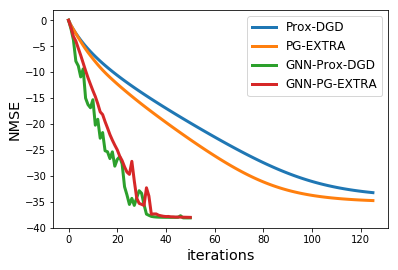

In [19]:
#plt.rc('text',usetex=True)nn
#plt.xscale('log')
long_end = 125
x_long = [i for i in range(long_end+1)]
plt.plot(x_long,origin_DGD_error[:long_end+1],linewidth=3)
plt.plot(x_long,origin_PGEXTRA_error[:long_end+1],linewidth=3)
#plt.plot(x_long,origin_NIDS_error[:long_end+1],linewidth=3)

x = [i for i in range(num_layers+1)]
plt.plot(x,pred_DGD_error[:num_layers+1],linewidth=3)
plt.plot(x,pred_PGEXTRA_error[:num_layers+1],linewidth=3)
#plt.plot(x,pred_NIDS_error[:num_layers+1],linewidth=3)

plt.legend(['Prox-DGD','PG-EXTRA','GNN-Prox-DGD','GNN-PG-EXTRA'],loc='upper right',fontsize='large') 
plt.xlabel('iterations',fontsize= 'x-large')
plt.ylabel('NMSE',fontsize= 'x-large')

figure_name = "D"+str(n)+"M"+str(m)+"NO"+str(nnz)
plt.savefig("./error_fig/noise1/"+figure_name+".eps")
plt.show()

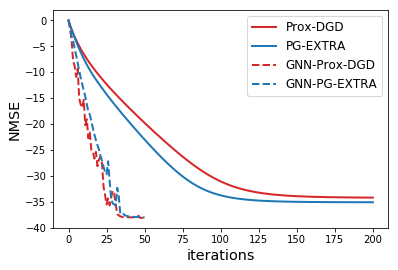

In [20]:
#plt.rc('text',usetex=True)nn
#plt.xscale('log')

long_end = 200
x_long = [i for i in range(long_end+1)]
plt.plot(x_long,origin_DGD_error[:long_end+1],linewidth=2,color = 'tab:red')
plt.plot(x_long,origin_PGEXTRA_error[:long_end+1],linewidth=2,color = 'tab:blue' )
#plt.plot(x_long,origin_NIDS_error[:long_end+1],linewidth=3)

x = [i for i in range(num_layers+1)]
plt.plot(x,pred_DGD_error[:num_layers+1],linewidth=2,linestyle='--',color = 'tab:red')
plt.plot(x,pred_PGEXTRA_error[:num_layers+1],linewidth=2,linestyle='--',color = 'tab:blue')
#plt.plot(x,pred_NIDS_error[:num_layers+1],linewidth=3)

plt.legend(['Prox-DGD','PG-EXTRA','GNN-Prox-DGD','GNN-PG-EXTRA'],loc='upper right',fontsize='large') 
plt.xlabel('iterations',fontsize= 'x-large')
plt.ylabel('NMSE',fontsize= 'x-large')

figure_name = "D"+str(n)+"M"+str(m)+"NO"+str(nnz)
plt.savefig("./error_fig/noise1/"+figure_name+".eps")
plt.show()